In [2]:
# SalesInsightsPreprocessing
from SamplingScript import *

# libraries to visualize
import matplotlib.pyplot as plt

# Import regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

## some stuff for making pretty plots
from matplotlib import rcParams
from cycler import cycler

from sklearn.model_selection import GridSearchCV

### Tensorflow and Keras imports ###
# Import TensorFlow for machine learning
import tensorflow as tf
# Import Keras for high-level neural networks API
from tensorflow import keras
# Import Dense and Activation layers for neural network architecture
from tensorflow.keras.layers import Dense, Activation
# Import Sequential for linear stacking of layers
from keras.models import Sequential
# Import KerasClassifier to make Keras models compatible with scikit-learn
from scikeras.wrappers import KerasClassifier, KerasRegressor

## Set plotting style and print options
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster
# Set figure format
wide_format, square_format = False, True
if wide_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.figsize': (9,6)}
if square_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,\
     'legend.fontsize': 12, 'font.family': 'serif', 'figure.figsize': (6,6)}
    
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)

#### Extra functions

In [3]:
training_data = [(X_train, y_train), (X_res_20k, y_res_20k), (X__res_50k, y_res_50k), (X_res_100k, y_res_100k)]
titles = ['OG df', '20k df', '50k df', '100k df']
dataframes = [df, df_resampled_20000, df_resampled_50000, df_resampled_100000]

In [68]:
def calculate_relative_errors(y_prediction):
    non_zero_mask = (y_test != 0)
    rel_error = np.mean(np.abs(y_test[non_zero_mask] - y_prediction[non_zero_mask]) / y_test[non_zero_mask])
    rel_error_med = np.median(np.abs(y_test[non_zero_mask] - y_prediction[non_zero_mask]) / y_test[non_zero_mask])
    rel_quan = np.quantile(np.abs(y_test[non_zero_mask] - y_prediction[non_zero_mask]) / y_test[non_zero_mask], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    mae = mean_absolute_error(y_test, y_prediction)
    mse = mean_squared_error(y_test, y_prediction)

    return rel_error, rel_error_med, rel_quan, mae, mse

In [5]:
def plot_true_vs_predicted(y_test, yPredLst, rSqrdLst):
    fig, ax = plt.subplots(ncols=len(titles), figsize=(15,5))
    ax = ax.flatten() 
    fig.suptitle('True vs predicted')

    for i in range(4):
        ax[i].plot(y_test, yPredLst[i], '.', markersize=1.5, alpha=.6)
        ax[i].set(xlabel='True value', ylabel='Predicted value', title=titles[i], ylim=[0,5000], xlim=[0,5000])
        ax[i].text(1000, 4000, rf'$R^2$ = {rSqrdLst[i]:.3f}', fontsize=12)

    fig.tight_layout()
    plt.show()

In [6]:
def plot_feature_importance(featImportLst):
    fig, ax = plt.subplots(ncols=len(titles), figsize=(15, 5))
    ax = ax.flatten()
    fig.suptitle('Feature Importance for Different Dataframes')

    for i in range(4):
        features = dataframes[i].drop(['Volume', 'Account Description', 'Size', 'Year Month (after 2000) in Datetime', 'Value'], axis=1).columns
        importances = featImportLst[i]
        indices = np.argsort(importances)
        
        ax[i].barh(features[indices], importances[indices])
        ax[i].set(xlabel='Importance', ylabel='Feature', title=titles[i])

    fig.tight_layout()
    plt.show()

#### Linear Regression

In [120]:
# Define parameter grid for LinearRegression
param_grid_linreg = {
    'fit_intercept': [True, False]
}

# Initialize LinearRegression
lin_reg = LinearRegression()

# Perform GridSearchCV
grid_linreg = GridSearchCV(lin_reg, param_grid_linreg, cv=5, n_jobs=-1)
grid_linreg.fit(X_train, y_train)

# Get the best estimator
best_linreg = grid_linreg.best_estimator_

r_sqrd_list_linreg = []
y_pred_list_linreg = []
perm_import_list_linreg = []
rel_med_error_list_linreg = []
metric_scores_linreg = []

for X, y in training_data:
    # fit and predict
    best_linreg.fit(X, y)
    y_pred = best_linreg.predict(X_test)
    
    # calculate the R^2 score
    rsquared = best_linreg.score(X_test, y_test)
    rel_error, rel_error_med, rel_quan, mae, mse = calculate_relative_errors(y_pred)
    perm_importance = permutation_importance(best_linreg, X_test, y_test, scoring='neg_mean_squared_error')
    y_pred_list_linreg.append(y_pred)
    r_sqrd_list_linreg.append(rsquared)
    perm_import_list_linreg.append(perm_importance.importances_mean)
    rel_med_error_list_linreg.append(rel_error_med)
    metric_scores_linreg.append((rsquared, rel_error * 100, rel_error_med * 100, mae, mse))
    print(f'Relative error: {rel_error * 100 :.3f} %')
    print(f'Relative median error: {rel_error_med * 100 :.3f} %')
    print(f'Relative quantile error: {rel_quan * 100} %')
    print(f'R squared: {rsquared:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print()

Relative error: 3164.181 %
Relative median error: 749.651 %
Relative quantile error: [  29.48425185   64.70478696  183.95469426  403.59637104  749.65070382
 1462.30968214 2978.46517608 4922.37843484 9167.74487382] %
R squared: 0.351
MAE: 203.766
MSE: 189930.569

Relative error: 3144.837 %
Relative median error: 726.471 %
Relative quantile error: [  29.80855349   62.16260616  171.1102474   398.44041022  726.47070362
 1426.5402929  3034.20241564 5083.85950118 9259.08982643] %
R squared: 0.354
MAE: 203.164
MSE: 189093.976

Relative error: 3130.806 %
Relative median error: 720.494 %
Relative quantile error: [  29.73698769   62.30350886  178.54024226  405.49869738  720.4938693
 1434.4169993  2952.55236253 4868.03246841 9068.92292137] %
R squared: 0.352
MAE: 203.553
MSE: 189662.130

Relative error: 3166.849 %
Relative median error: 752.288 %
Relative quantile error: [  29.85424094   63.32932654  185.97356676  407.20005297  752.2876807
 1487.93903244 2978.27553462 4874.59705665 9158.32795964]

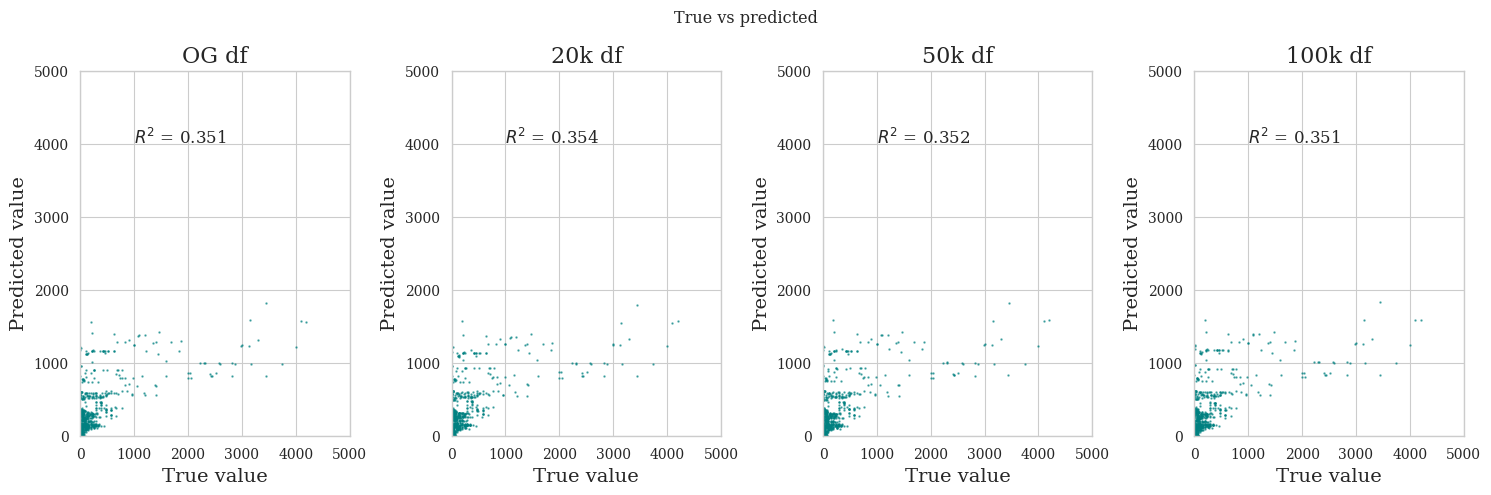

In [121]:
plot_true_vs_predicted(y_test, y_pred_list_linreg, r_sqrd_list_linreg)

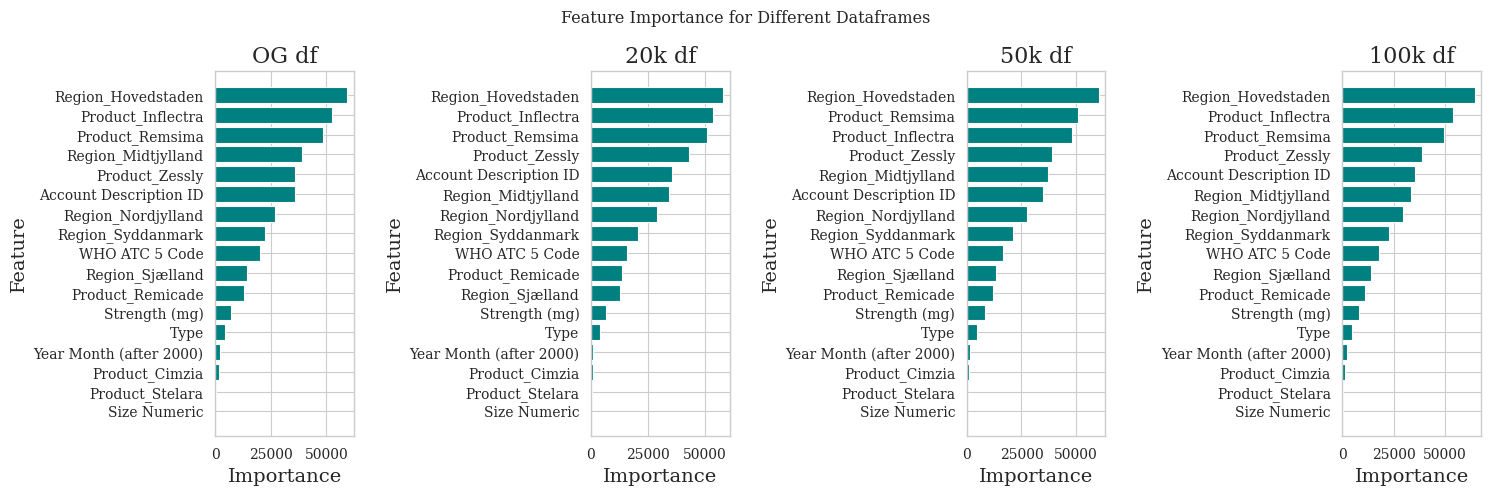

In [122]:
plot_feature_importance(perm_import_list_linreg)

#### Random Forest with hyperparameter tuning

In [107]:
# Define parameter grid for RandomForestRegressor
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForestRegressor
ran_for_reg = RandomForestRegressor(random_state=42)

# Perform GridSearchCV
grid_rf = GridSearchCV(ran_for_reg, param_grid_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Get the best estimator
best_rf = grid_rf.best_estimator_

y_pred_list_ranfor = []
r_sqrd_list_ranfor = []
feat_import_list_ranfor = []
rel_med_error_list_ranfor = []
metric_scores_ranfor = []

for X, y in training_data:
    # fit and predict
    best_rf.fit(X, y)
    y_pred = best_rf.predict(X_test)

    # calculate the R^2 score
    rsquared = best_rf.score(X_test, y_test)

    non_zero_mask = (y_test != 0)
    rel_error, rel_error_med, rel_quan, mae, mse = calculate_relative_errors(y_pred)
    
    y_pred_list_ranfor.append(y_pred)
    r_sqrd_list_ranfor.append(rsquared)
    feat_import_list_ranfor.append(best_rf.feature_importances_)
    rel_med_error_list_ranfor.append(rel_error_med)
    metric_scores_ranfor.append((rsquared, rel_error * 100, rel_error_med * 100, mae, mse))
    print(f'Relative error: {rel_error * 100 :.3f} %')
    print(f'Relative median error: {rel_error_med * 100 :.3f} %')
    print(f'Relative quantile error: {rel_quan * 100} %')
    print(f'R squared: {rsquared:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print()

c:\Users\Josef\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Relative error: 162.694 %
Relative median error: 22.172 %
Relative quantile error: [ 4.41721063  9.93110847 13.69767412 17.88847    22.17214977 28.21675555
 37.88570902 51.64890644 94.71479165] %
R squared: 0.790
MAE: 48.706
MSE: 61561.554

Relative error: 111.745 %
Relative median error: 24.268 %
Relative quantile error: [ 4.50856714  9.17177924 14.0094578  18.6486343  24.26824198 29.36451592
 37.44662898 53.13902811 96.49635876] %
R squared: 0.774
MAE: 50.966
MSE: 66129.435

Relative error: 101.678 %
Relative median error: 23.986 %
Relative quantile error: [ 4.04416421  9.21650298 13.2491923  19.06651559 23.9861918  30.15073228
 39.16531924 54.21416809 99.97319706] %
R squared: 0.770
MAE: 51.569
MSE: 67183.844

Relative error: 91.250 %
Relative median error: 23.870 %
Relative quantile error: [ 3.80506987  8.72176763 12.98271144 18.01088699 23.87006169 28.65221135
 38.3195635  53.30192869 99.05308055] %
R squared: 0.770
MAE: 51.453
MSE: 67147.715



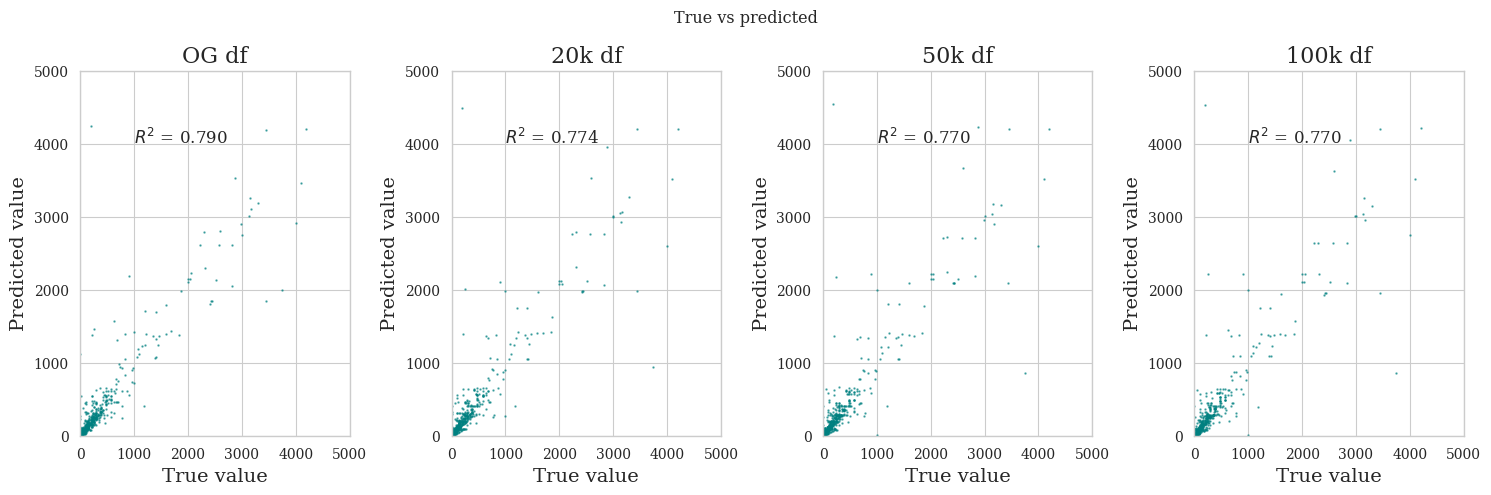

In [108]:
plot_true_vs_predicted(y_test, y_pred_list_ranfor, r_sqrd_list_ranfor)

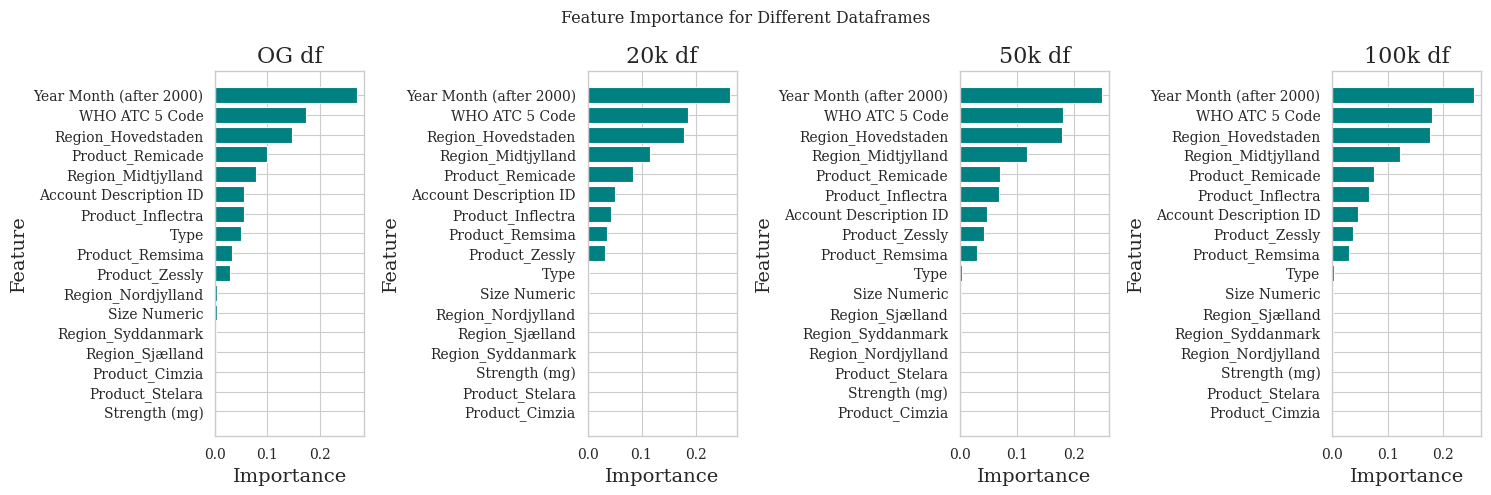

In [109]:
plot_feature_importance(feat_import_list_ranfor)

#### XGBoost

In [110]:
# Define parameter grid for XGBRegressor
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize XGBRegressor
xgb = XGBRegressor()

# Perform GridSearchCV
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# Get the best estimator
best_xgb = grid_xgb.best_estimator_

y_pred_list_xgb = []
r_sqrd_list_xgb = []
feat_import_list_xgb = []
rel_med_error_list_xgb = []
metric_scores_xgb = []

for x, y in training_data:
    # fit and predict
    best_xgb.fit(x, y)
    y_pred_xgb = best_xgb.predict(X_test)

    # calculate the R^2 score
    rsquared_xgb = best_xgb.score(X_test, y_test)

    non_zero_mask = (y_test != 0)
    rel_error, rel_error_med, rel_quan, mae, mse = calculate_relative_errors(y_pred_xgb)
    
    y_pred_list_xgb.append(y_pred_xgb)
    r_sqrd_list_xgb.append(rsquared_xgb)
    feat_import_list_xgb.append(best_xgb.feature_importances_)
    rel_med_error_list_xgb.append(rel_error_med)
    metric_scores_xgb.append((rsquared_xgb, rel_error * 100, rel_error_med * 100, mae, mse))
    print(f'Relative error: {rel_error * 100 :.3f} %')
    print(f'Relative median error: {rel_error_med * 100 :.3f} %')
    print(f'Relative quantile error: {rel_quan * 100} %')
    print(f'R squared: {rsquared_xgb:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print()

Relative error: 276.152 %
Relative median error: 49.520 %
Relative quantile error: [  5.68943422  13.72166105  22.6533692   33.79986536  49.51993227
  74.75156784 120.53833571 191.38594627 300.78302383] %
R squared: 0.771
MAE: 55.629
MSE: 66951.956

Relative error: 229.197 %
Relative median error: 44.839 %
Relative quantile error: [  6.05576966  13.95072341  20.76569843  31.79448528  44.8393914
  62.07879941  93.35124898 150.99417432 277.37812996] %
R squared: 0.770
MAE: 55.264
MSE: 67224.861

Relative error: 250.683 %
Relative median error: 44.816 %
Relative quantile error: [  6.00021103  13.72957876  21.40028415  31.50055962  44.81573105
  61.00721798  88.46724647 141.04847126 262.68407949] %
R squared: 0.764
MAE: 56.271
MSE: 69001.287

Relative error: 262.005 %
Relative median error: 46.772 %
Relative quantile error: [  7.09560521  14.06717606  22.15537204  32.27671627  46.7724644
  66.28870419 102.23575232 171.83491071 280.2616024 ] %
R squared: 0.762
MAE: 56.831
MSE: 69541.594



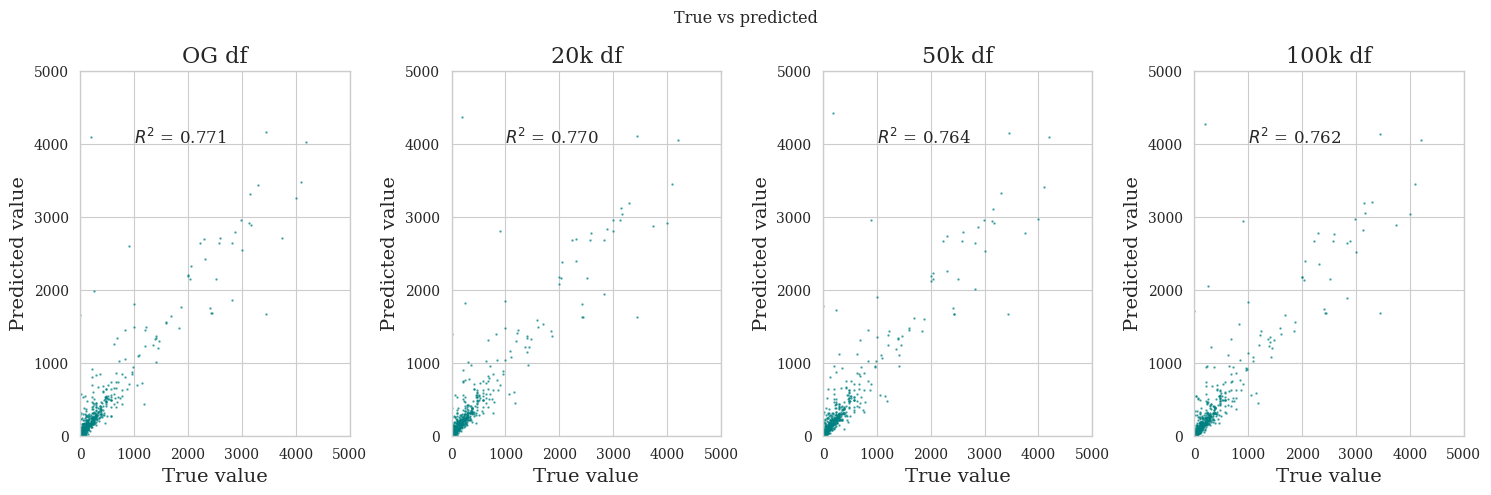

In [111]:
plot_true_vs_predicted(y_test, y_pred_list_xgb, r_sqrd_list_xgb)

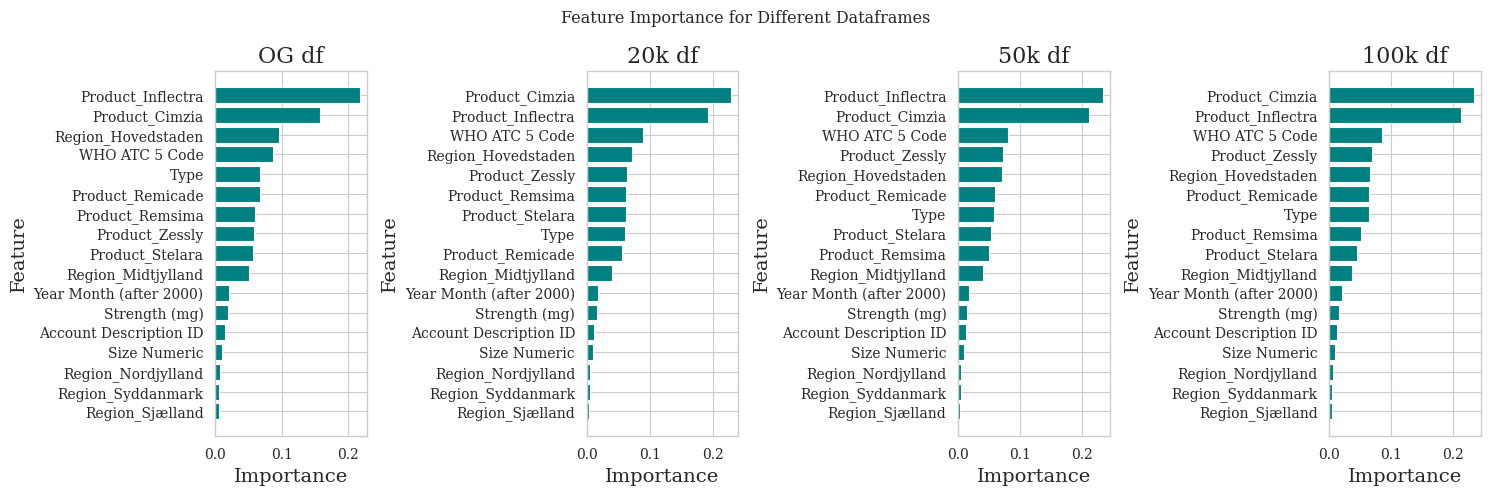

In [112]:
plot_feature_importance(feat_import_list_xgb)

#### Model comparisons

In [114]:
# Collect all the predictions from different models
results = {
    'Linear Regression': metric_scores_linreg[1],
    'Random Forest': metric_scores_ranfor[0],
    'XGBoost': metric_scores_xgb[0]
}

# Convert the results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

results_df

,Linear Regression,Random Forest,XGBoost
0,0.353539,0.789538,0.771109
1,3144.837418,162.693599,276.151530
2,726.470704,22.172150,49.519932
3,203.163537,48.705911,55.629043
4,189093.975963,61561.553740,66951.956285


Text(0.5, 1.02, 'Evaluation Metrics for Different Models')

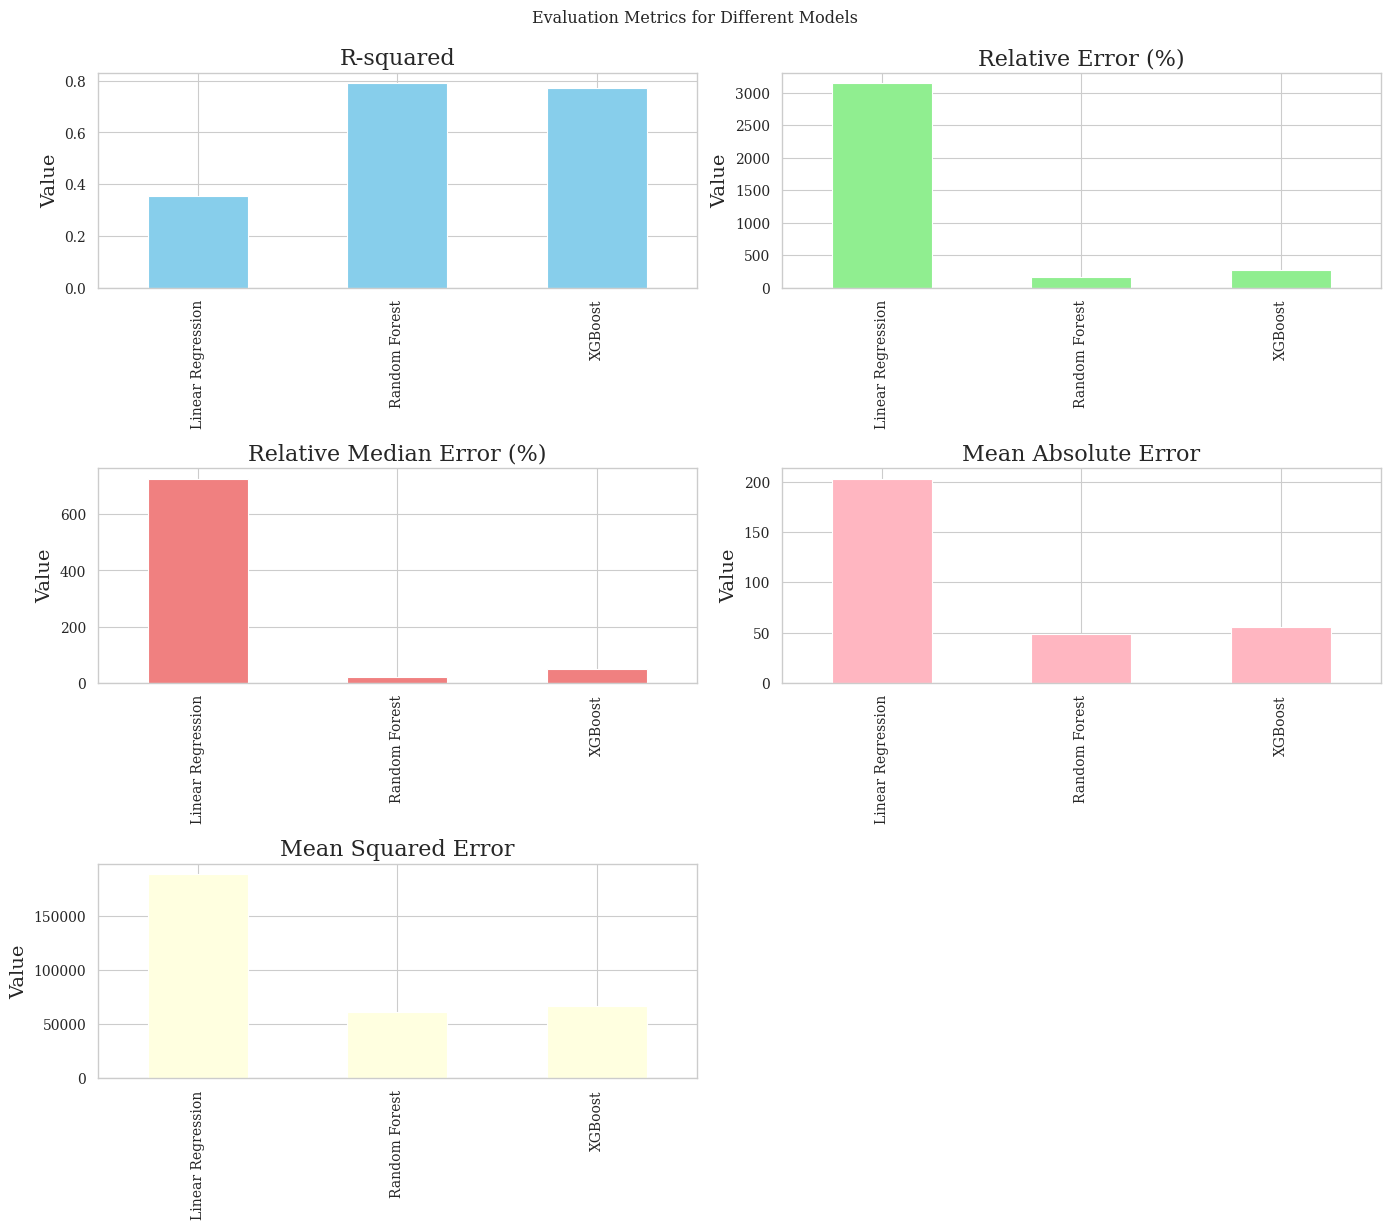

In [115]:
# Assuming you have the evaluation metrics stored in dictionaries
r_squared = {model: results[model][0] for model in results}
rel_error = {model: results[model][1] for model in results}
rel_med_error = {model: results[model][2] for model in results}
mae = {model: results[model][3] for model in results}
mse = {model: results[model][4] for model in results}

# Convert dictionaries to DataFrame for easier plotting
metrics_df = pd.DataFrame([r_squared, rel_error, rel_med_error, mae, mse], index=['R-squared', 'Relative Error', 'Relative Median Error', 'MAE', 'MSE']).T

# Plot bar plot
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Plot each metric in a separate subplot
metrics_df[['R-squared']].plot(kind='bar', ax=axes[0, 0], legend=False, color='skyblue')
axes[0, 0].set_title('R-squared')
axes[0, 0].set_ylabel('Value')

metrics_df[['Relative Error']].plot(kind='bar', ax=axes[0, 1], legend=False, color='lightgreen')
axes[0, 1].set_title('Relative Error (%)')
axes[0, 1].set_ylabel('Value')

metrics_df[['Relative Median Error']].plot(kind='bar', ax=axes[1, 0], legend=False, color='lightcoral')
axes[1, 0].set_title('Relative Median Error (%)')
axes[1, 0].set_ylabel('Value')

metrics_df[['MAE']].plot(kind='bar', ax=axes[1, 1], legend=False, color='lightpink')
axes[1, 1].set_title('Mean Absolute Error')
axes[1, 1].set_ylabel('Value')

metrics_df[['MSE']].plot(kind='bar', ax=axes[2, 0], legend=False, color='lightyellow')
axes[2, 0].set_title('Mean Squared Error')
axes[2, 0].set_ylabel('Value')

# Hide the empty subplot
fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.suptitle('Evaluation Metrics for Different Models', y=1.02)
# plt.show()